In [4]:
import tensorflow as tf
import numpy as np
import glob
import os
from PIL import Image , ImageOps
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras.callbacks import *

In [5]:
train_dir = '../input/u-net-data/Dataset/Train'
test_dir = '../input/u-net-data/Dataset/Test'
size_image = 128


In [6]:
def read_image(dir, size= 256):
    x = list()
    y = list()
    image_filenames = os.listdir(dir)
    for filename in image_filenames[0 : len(image_filenames)]:
        image = Image.open(os.path.join(dir, filename))
        x.append(np.asarray(ImageOps.crop(image, (0, 0, 256, 0)).resize((size, size))))
        y.append(np.asarray(ImageOps.crop(image, (256, 0, 0, 0)).resize((size, size))))

    x = np.array( x ) / 255
    y = np.array( y )
    return x, y

In [7]:
X_test, Y_test = read_image(test_dir, size=size_image)

In [8]:
X_train, Y_train = read_image(train_dir, size=size_image)

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Original", "Mask", "Predicted"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.show()

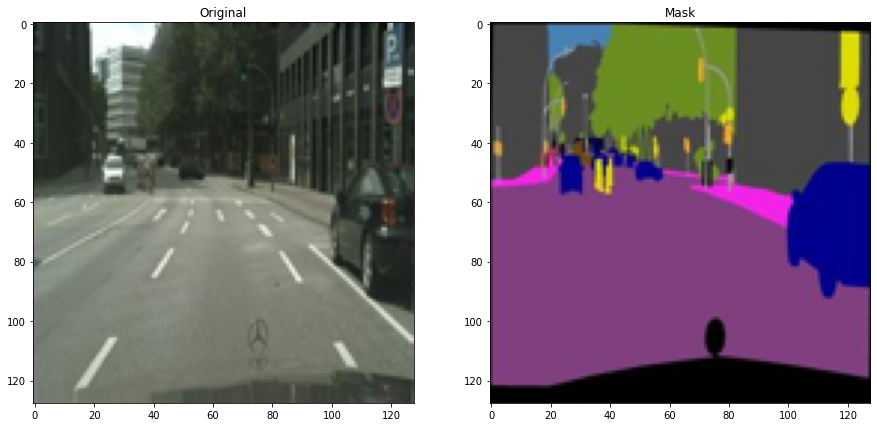

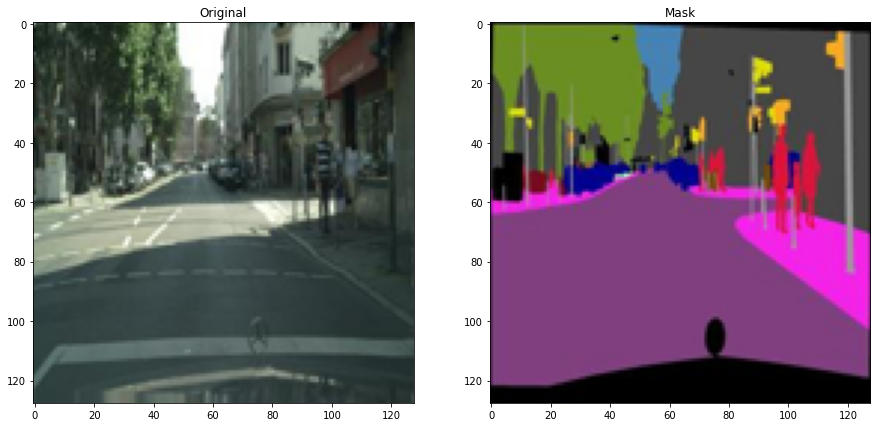

In [10]:
display([X_train[0], Y_train[0]])
display([X_test[0], Y_test[0]])

In [11]:
num_classes = 20
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light',
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus',
               'train', 'motorcycle', 'bicycle']
colors = [
    [0,   0,   0],
    [128, 64, 128],
    [244, 35, 232],
    [70, 70, 70],
    [102, 102, 156],
    [190, 153, 153],
    [153, 153, 153],
    [250, 170, 30],
    [220, 220, 0],
    [107, 142, 35],
    [152, 251, 152],
    [0, 130, 180],
    [220, 20, 60],
    [255, 0, 0],
    [0, 0, 142],
    [0, 0, 70],
    [0, 60, 100],
    [0, 80, 100],
    [0, 0, 230],
    [119, 11, 32],
]
cluster_centers = np.array(colors)
cluster_centers

array([[  0,   0,   0],
       [128,  64, 128],
       [244,  35, 232],
       [ 70,  70,  70],
       [102, 102, 156],
       [190, 153, 153],
       [153, 153, 153],
       [250, 170,  30],
       [220, 220,   0],
       [107, 142,  35],
       [152, 251, 152],
       [  0, 130, 180],
       [220,  20,  60],
       [255,   0,   0],
       [  0,   0, 142],
       [  0,   0,  70],
       [  0,  60, 100],
       [  0,  80, 100],
       [  0,   0, 230],
       [119,  11,  32]])

In [12]:
label_model = KMeans(n_clusters = num_classes, init=cluster_centers, n_init=1)
label_model.fit(cluster_centers)

KMeans(init=array([[  0,   0,   0],
       [128,  64, 128],
       [244,  35, 232],
       [ 70,  70,  70],
       [102, 102, 156],
       [190, 153, 153],
       [153, 153, 153],
       [250, 170,  30],
       [220, 220,   0],
       [107, 142,  35],
       [152, 251, 152],
       [  0, 130, 180],
       [220,  20,  60],
       [255,   0,   0],
       [  0,   0, 142],
       [  0,   0,  70],
       [  0,  60, 100],
       [  0,  80, 100],
       [  0,   0, 230],
       [119,  11,  32]]),
       n_clusters=20, n_init=1)

In [13]:
def check_kmeans(label_model, X_train, Y_train, size_image=128):
    for i in range(10, 12):
        testing_img_orig = X_train[i]
        testing_img_mask = Y_train[i]
        label_class = label_model.predict(testing_img_mask.reshape(-1,3))

        rgb_cols = label_model.cluster_centers_.round(0).astype(int)
        img_quant = np.reshape(rgb_cols[label_class],(size_image,size_image,3))

        fig, axes = plt.subplots(1,4,figsize=(15,5))
        axes[0].imshow(testing_img_orig)
        axes[1].imshow(testing_img_mask)
        axes[2].imshow(label_class.reshape(size_image,size_image))
        axes[3].imshow(img_quant)
    return rgb_cols

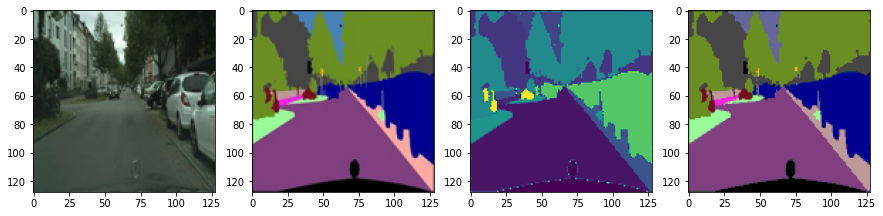

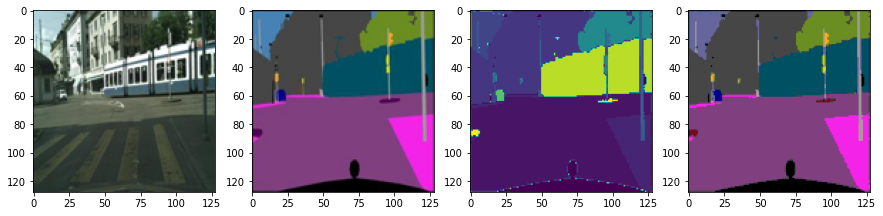

In [14]:
rgb_cols = check_kmeans(label_model, X_train, Y_train)

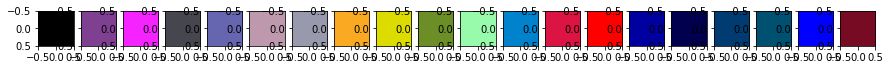

In [15]:
def print_class_color(rgb_cols, num_classes=20):
    fig, axes = plt.subplots(1,num_classes,figsize=(15,5))    
    for i, rgb in enumerate(rgb_cols):
        axes[i].imshow([[(rgb[0]/255, rgb[1]/255, rgb[2]/225)]])
        
print_class_color(rgb_cols)

In [16]:
def make_labels(label_model, Y_in, size_image=128):
    labels = np.empty((0, size_image, size_image))
    for i in tqdm(range(len(Y_in))):
        label_class = label_model.predict(Y_in[i].reshape(-1,3)).reshape(1, size_image,size_image)
        labels = np.append(labels, label_class, axis=0)
        
    return labels

In [17]:
train_labels = make_labels(label_model, Y_train)

100%|██████████| 1500/1500 [01:01<00:00, 24.49it/s]


In [18]:
test_labels = make_labels(label_model, Y_test)

100%|██████████| 200/200 [00:00<00:00, 246.88it/s]


In [19]:
def conv2d_block(input_layer, n_filters, kernel_size = 3):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', activation='relu')(x)
    x = BatchNormalization()(x)
    return x

In [23]:
def create_unet(input_size = (256,256,3), n_classes = 20, n_filters = 16, dropout = 0.1):
    
    inputs_ = Input(input_size)
    c1 = conv2d_block(inputs_, n_filters * 1, kernel_size = 3)
    p1 = MaxPooling2D(padding='same')(c1)
    p1 = Dropout(dropout/2)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3)
    p2 = MaxPooling2D(padding='same')(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3)
    p3 = MaxPooling2D(padding='same')(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3)
    p4 = MaxPooling2D(padding='same')(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3)
    
    u6 = Conv2DTranspose(n_filters * 8, 2, strides=2, padding='same', activation='relu')(c5)
    u6 = BatchNormalization()(u6) 
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3)
    
    
    u7 = Conv2DTranspose(n_filters * 4, 2, strides=2, padding='same', activation='relu')(c6)
    u7 = BatchNormalization()(u7) 
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3)
    
    
    u8 = Conv2DTranspose(n_filters * 2, 2, strides=2, padding='same', activation='relu')(c7)
    u8 = BatchNormalization()(u8) 
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3)
    
    
    u9 = Conv2DTranspose(n_filters * 1, 2, strides=2, padding='same', activation='relu')(c8)
    u9 = BatchNormalization()(u9) 
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3)
    
    c10 = Conv2D(n_classes, 1, activation = 'softmax')(c9)

    model = Model(inputs=[inputs_], outputs=[c10])
    model.summary()

    return model


In [25]:
unet = create_unet(input_size=(size_image,size_image,3), n_classes = num_classes,\
                  n_filters=64, dropout=0.5)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 128, 128, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 36928       batch_normalization_22[0][0]     
____________________________________________________________________________________________

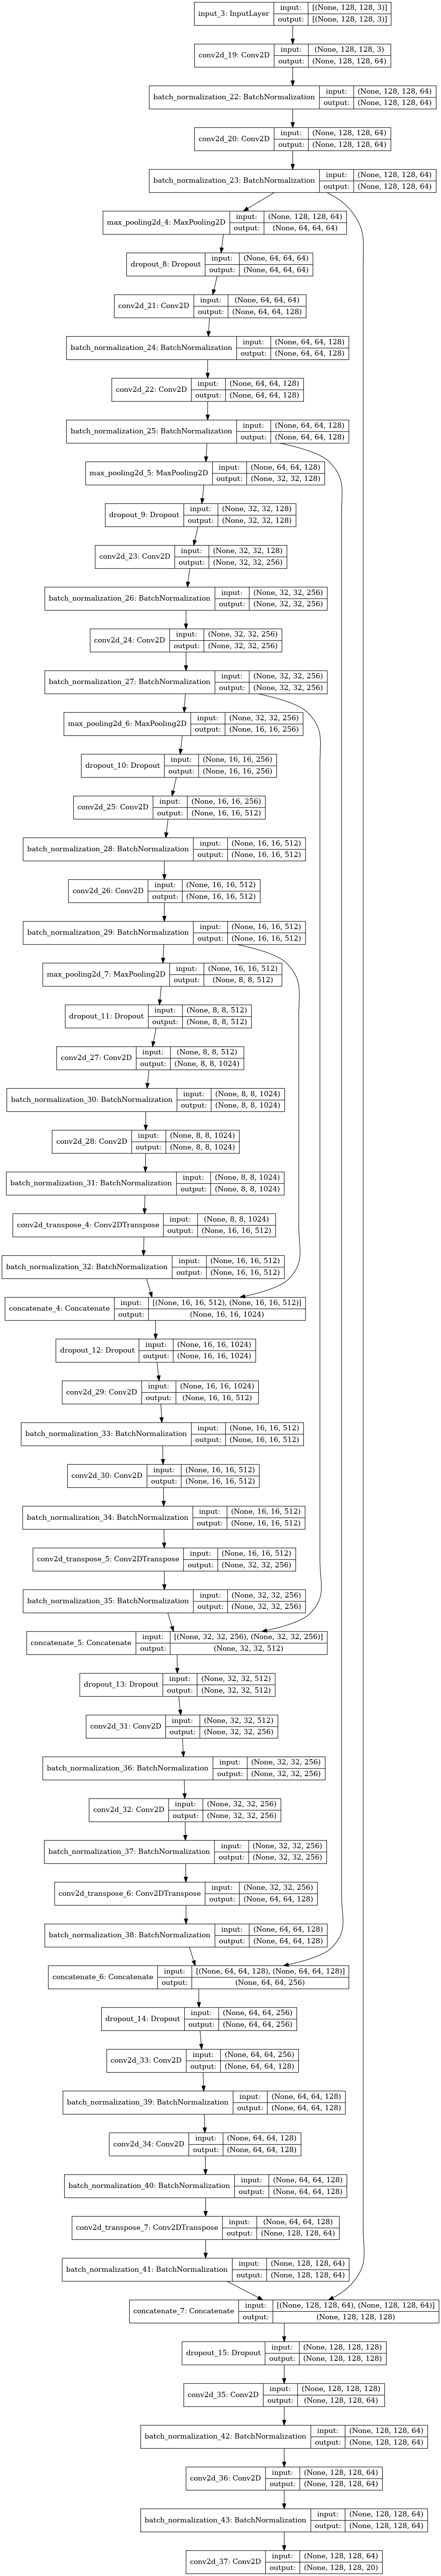

In [26]:
img_file = './model_arch.png'
tf.keras.utils.plot_model(unet, to_file=img_file, show_shapes=True)

In [27]:
def callbacks(patience=10):
#     checkpoint = ModelCheckpoint('unet1.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
#     early = EarlyStopping(monitor='loss',patience=patience)
#         EarlyStopping(patience=patience, verbose=1),
#     callbacks_list=[checkpoint, early]
    callbacks_list = [
        ReduceLROnPlateau(factor=0.1, patience=patience, min_lr=0.001, verbose=1),
        ModelCheckpoint('unet1.h5', verbose=1, save_best_only=True, save_weights_only=True)
    ]
    return callbacks_list

In [28]:
BATCH_SIZE = 16
steps_per_epoch = 1500 // BATCH_SIZE
validation_steps = 200 // BATCH_SIZE

In [29]:
# unet.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),\
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(),\
#              metrics=['accuracy'])
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'])
# results = unet.fit(X_train, train_labels, batch_size=16, epochs=200,validation_split=0.3,\
#                    callbacks=callbacks(patience=10))
results = unet.fit(X_train, train_labels, steps_per_epoch=steps_per_epoch,\
                   validation_split=0.3, validation_steps=validation_steps, epochs=80,\
                   callbacks=callbacks(patience=10))


2022-07-10 13:12:52.661685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80


2022-07-10 13:12:55.737537: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


93/93 [==============================] - 30s 205ms/step - loss: 1.3196 - acc: 0.6307 - val_loss: 94.3120 - val_acc: 0.0011

Epoch 00001: val_loss improved from inf to 94.31200, saving model to unet1.h5
Epoch 2/80
93/93 [==============================] - 11s 118ms/step - loss: 0.9239 - acc: 0.7318 - val_loss: 8.4344 - val_acc: 0.1339

Epoch 00002: val_loss improved from 94.31200 to 8.43436, saving model to unet1.h5
Epoch 3/80
93/93 [==============================] - 11s 118ms/step - loss: 0.8523 - acc: 0.7544 - val_loss: 4.6064 - val_acc: 0.3080

Epoch 00003: val_loss improved from 8.43436 to 4.60636, saving model to unet1.h5
Epoch 4/80
93/93 [==============================] - 11s 118ms/step - loss: 0.8040 - acc: 0.7672 - val_loss: 1.6213 - val_acc: 0.6174

Epoch 00004: val_loss improved from 4.60636 to 1.62127, saving model to unet1.h5
Epoch 5/80
93/93 [==============================] - 11s 118ms/step - loss: 0.7647 - acc: 0.7793 - val_loss: 0.9413 - val_acc: 0.7387

Epoch 00005: val_l

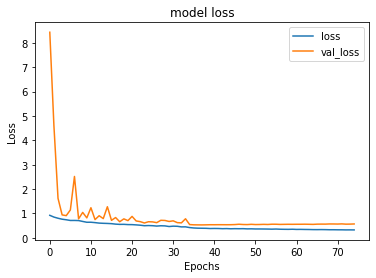

In [72]:
plt.plot(results.history['loss'][1:], label="loss")
plt.plot(results.history["val_loss"][1:], label="val_loss")
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()


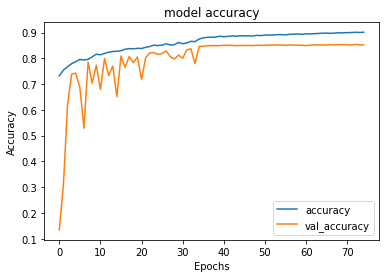

In [73]:
plt.plot(results.history['acc'][1:], label='accuracy')
plt.plot(results.history["val_acc"][1:], label="val_accuracy")
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [36]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [32]:
pred = unet.predict(X_test)
y_pred = tf.argmax(pred,axis=-1)

[194 108  22 194 181 149  80  92 195 148]


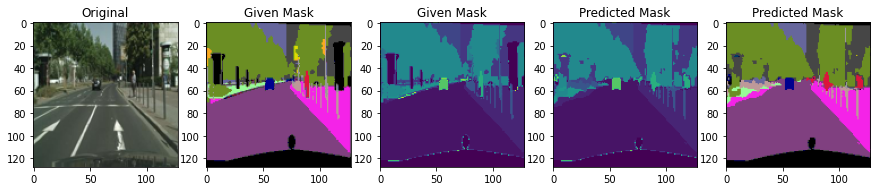

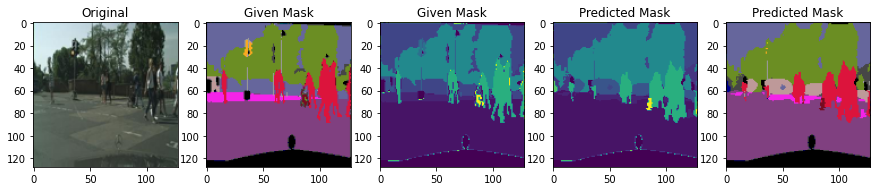

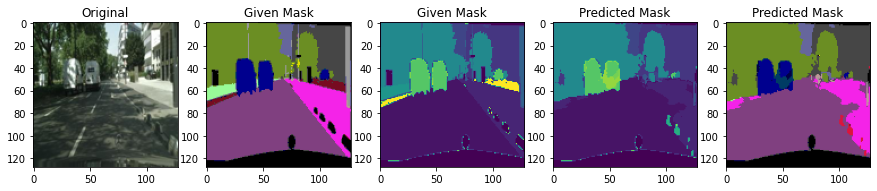

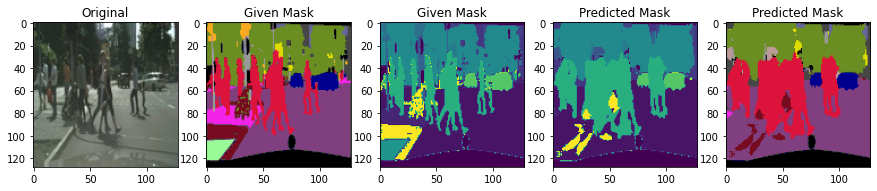

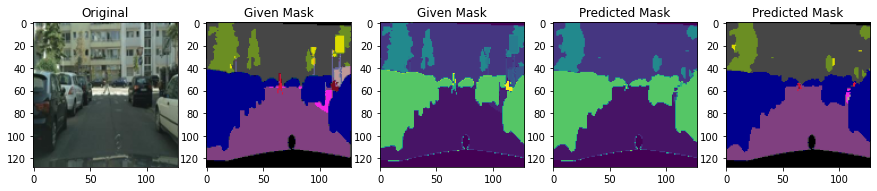

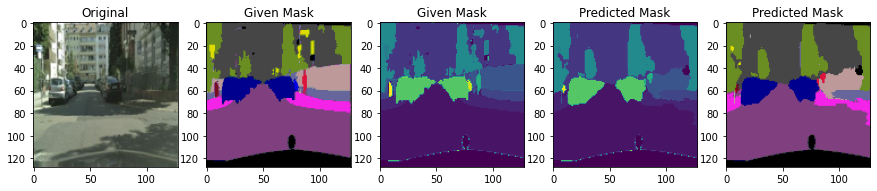

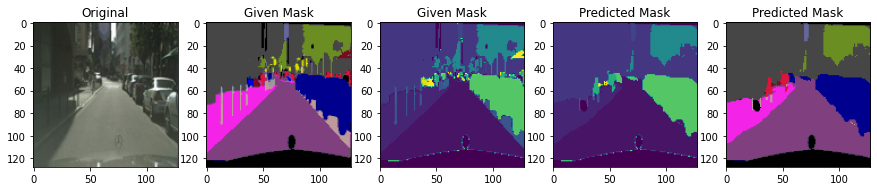

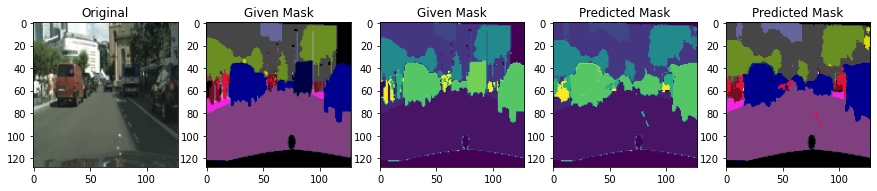

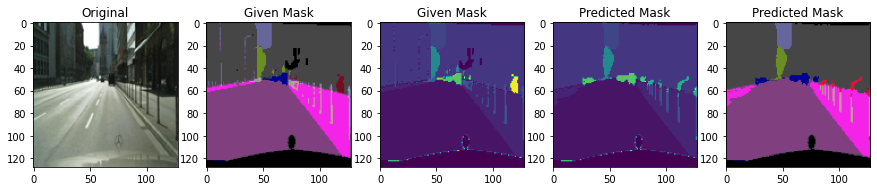

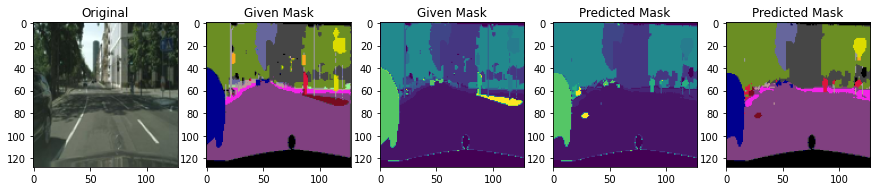

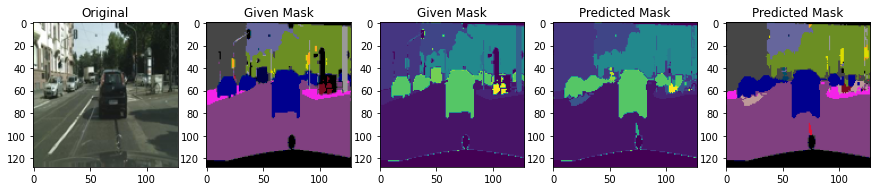

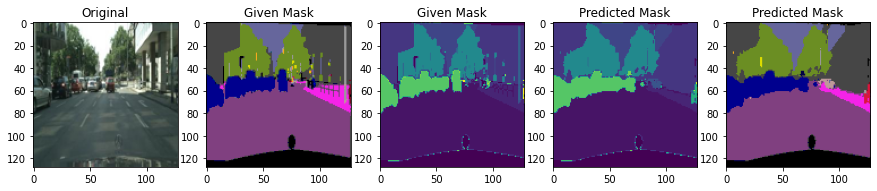

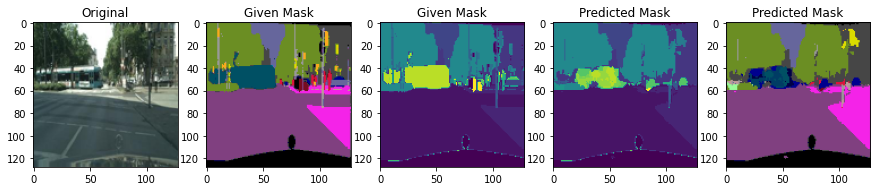

In [67]:
rand_index = np.random.randint(len(test_labels), size=10)
for i in rand_index:
    testing_img_orig = X_test[i]
    testing_img_mask = test_labels[i].astype('int')
    testing_img_pred = y_pred[i]
    
    img_mask = np.reshape(rgb_cols[testing_img_mask],(size_image,size_image,3))
    img_quant = np.reshape(rgb_cols[testing_img_pred],(size_image,size_image,3))
    
    fig, axes = plt.subplots(1,5,figsize=(15,5))
    axes[0].imshow(testing_img_orig)
    axes[0].set_title('Original')
    axes[1].imshow(img_mask)
    axes[1].set_title('Given Mask')
    axes[2].imshow(test_labels[i])
    axes[2].set_title('Given Mask')
    axes[3].imshow(testing_img_pred.reshape(size_image,size_image))
    axes[3].set_title('Predicted Mask')
    axes[4].imshow(img_quant)
    axes[4].set_title('Predicted Mask')